In [ ]:
from google.colab import drive

DRIVE_PATH = '/content/drive'
drive.mount(DRIVE_PATH)

Mounted at /content/drive


# Libraries Installation

In [ ]:
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 2.2 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=fdd5e1c3d7373206ae858571d1dbd745b16f339abf72e6490aa15c969a76fc1f
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


# Libraries Import

In [ ]:
import warnings

# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.cm import get_cmap

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

# Encoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# Cluster model
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from pyclustering.cluster.clarans import clarans
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix

# Timer
from multiprocessing import Process, Manager

# Visualization
from pyclustering.cluster import cluster_visualizer

# Tuning Classes


> TuningModel - A Basic(Parent) class for hyperparameter tuning

*   Public Methods:

 **Constructor(param)**
  - @param **param** - dictionary: parameters for tuning

 **fit(x)**
 
 - @param **x** - np.ndarray: Dataframe values for modeling

 **check_best()**
  - Check the best model with scores

 **plot_score(title)**
  - Plot the average score for each key parameters
  - @param **title** - str: Title of plot

* Protected Methods

 **_model_execute(x, params)**
  - @param **x** - np.ndarray: dataframe values
  - @param **params** - dictionary: chosen parameters in whole parameter

 **_model_scoring(model, x)**
  - @param **model** - Any: Data model built in *_model_execute*
  - @param **x** - numpy.ndarray: dataframe values

 **_is_best(model)**
  - @param **model** - Any: Data model built in *_model_execute* compares with the best score

*   Members

 *params*

 - parameter input from constructor

 *model_list*

 - model list, availiable after using **fit**

 *best_params_*

 - best model's parameters, availiable after using **fit**

 *best_score_*

 - best model's score, availiable after using **fit**

 *best_model_*

 - best model, availiable after using **fit**


In [ ]:
class TuningModel:
    def __init__(self, param: dict, timer=900):
        self.params = param
        self.model_list = []

        self.best_params_ = None
        self.best_score_ = None
        self.best_model_ = None

        self._dataset = None
        self.__timer = timer

    def _model_execute(self, x, params, result):
        pass

    def _model_scoring(self, model, x):
        pass

    def _is_best(self, model):
        return self.best_score_ is None or self.best_score_ < model['score']

    def check_best(self):
        for result in self.model_list:
            if self._is_best(result):
                self.best_score_ = result['score']
                self.best_params_ = result['params']
                self.best_model_ = result['model']

    def fit(self, x):
        if self.params is None:
            raise Exception('Invalid parameters input: None', 'ParameterError')

        self._dataset = x

        # Traversal for whole indices with digits
        # By computing the digits of each index
        #
        # Examples:
        #
        # Consider three digits (4, 2, 2) - in specific (quadratic, binary, binary)
        # We can get series of numbers:
        # 0 0 0 = 0(10)
        # 0 0 1 = 1
        # 0 1 0 = 2
        # ...
        # 3 0 0 = 12
        # 3 0 1 = 13
        # 3 1 0 = 14
        # 3 1 1 = 15
        #
        # In this case - we can explain the result number as
        # 15 = 3 * (2 * 2) + 1 * (2) + 1
        #
        # Similarly, we can apply them in traversal
        # length = 15 -> get indices (3, 1, 1) for clarans - {'n_cluster', 'num_local', 'max_neighbor'}
        # By using this, we visit whole parameters.

        length = 1
        param_keys = []

        # 1. Calc the total multiple of length, and the individual length
        for key, value in self.params.items():
            length *= len(value)
            param_keys.append(key)

        if length == 0:
            raise Exception('Invalid parameters input: No parameters input', 'ParameterError')

        # 2. Loop until the length became 0
        while length > 0:
            params = {}

            temp = length - 1
            for i, key in enumerate(param_keys):
                # 2-1. Calculate the total multiple of the lower digits
                remain = 1
                for next_key in param_keys[i + 1:]:
                    remain *= len(self.params[next_key])

                # 2-2. Compute index (div)
                index = temp // remain

                # 2-3. Remove current digit number (4 2 2) -> (2 2)
                temp -= index * remain
                params[key] = self.params[key][index]

            return_dict = Manager().dict()

            # Process the modeling on separated thread using Process
            # Returns None when the time exceed self.__timer
            process = Process(target=self._model_execute, args=(x, params, return_dict))
            process.start()
            process.join(timeout=self.__timer)
            process.terminate()

            length -= 1

            if len(return_dict) == 0:
                warnings.warn(f'Timeout from {self}: Model with {params} exceed {self.__timer}. Model ignored.',
                              UserWarning)
                continue

            model = return_dict['return']

            self.model_list.append({
                'params': params,
                'model': model,
                'score': self._model_scoring(model, x)
            })

        self.check_best()

    def plot_score(self, title: str):
        fig, axs = plt.subplots(3, (len(self.params) + 2) // 3, figsize=(10, 10), constrained_layout=True)
        plt.suptitle(title)

        x = 0
        for key, values in self.params.items():
            value_list, score_list = [], []

            for value in values:
                avg_score, quantity = 0, 0
                for model in self.model_list:
                    if model['params'][key] == value:
                        avg_score += model['score']
                        quantity += 1

                if quantity == 0:
                    continue

                value_list.append(value)
                score_list.append(avg_score / quantity)

            axs[x].set_title(f'Average score based on the value of {key}')
            axs[x].plot(value_list, score_list)
            axs[x].set_xlabel(str(key))
            axs[x].set_ylabel('score')

            x += 1

> ClaransTune - Tuning class for pyclustering.cluster.clarans.clarans
- uses **silhouette coefficient** for scoring
- **Constructor(method, param)**
  - @param **method**: matrice calculation method - 'euclidean', 'manhattan', ..

In [ ]:
class ClaransTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self._metric = method

    def _model_execute(self, x, params, return_dict):
        # Order dictionary to tuple for parameter input
        param_input = (params['number_clusters'], params['numlocal'], params['maxneighbor'])

        # Input it as parameter
        model = clarans(x, *param_input)
        model.process()

        return_dict['return'] = model

    def _model_scoring(self, model: clarans, x):
        # Match the form of clusters [[cluster1], [cluster2], ...] -> [c1, c2, c1, ...]
        y = np.zeros(x.size // x[0].size)
        for i in range(0, len(model.get_clusters())):
            for index in model.get_clusters()[i]:
                y[index] = i + 1

        return silhouette_score(x, y, metric=self._metric)

    def plot_score(self, title):
        super.plot_score(self, title)
        visualizer = cluster_visualizer(10, 4)

    def plot_score(self, title: str):
        # 4+Dimensional cannot be visualized
        if 0 < self._dataset.shape[0] < 4:
            visualizer = cluster_visualizer(10, 4)  # 시각적 그래프

            # for result in self.model_list: - Too many models, print the best one only.
            model = self.best_model_

            # Obtain medoid, cluster from model
            medoids = model.get_medoids()
            clusters = model.get_clusters()

            k = self.best_params_['number_clusters']

            visualizer.append_clusters(clusters, self._dataset, k - 3)  # cluster 시각화
            visualizer.append_cluster(medoids, self._dataset, k - 3, marker='x')  # center 좌표 시각화
            visualizer.set_canvas_title(text=f'Clarans Cluster : {k}', canvas=k - 3)
            visualizer.show(figure=plt.figure(figsize=(10,10)))

        super(ClaransTune, self).plot_score(title)


Other clusters
> DbscanTune - Tuning class for sklearn.cluster.DBSCAN

> KMeansTune - Tuning class for sklearn.cluster.KMeans

> GMMTune - Tuning class for sklearn.mixture.GaussianMixture

> MeanShift - Tuning class for sklearn.cluster.MeanShift

- uses **silhouette coefficient** for scoring
- **Constructor(method, param)**
  - @param **method**: matrice calculation method - 'euclidean', 'manhattan', ...

In [ ]:
class DbscanTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self._metric = method

    def _model_execute(self, x, params, return_dict):
        model = DBSCAN(**params) # send input parameter as keyword to constructor
        model.fit(x)

        return_dict['return'] = model

    def _model_scoring(self, model: DBSCAN, x):
      # Error handling: Number of cluster < 2
      # DBSCAN does not clearify the number of clusters first
      # When we use silhouette score, we can get case of 1 cluster model
      # Return -1 (worst score) when no clustering
        try:
            score = silhouette_score(x, model.labels_, metric=self._metric)
        except ValueError:
            return -1.0

        return score


class KMeansTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self._metric = method

    def _model_execute(self, x, params, return_dict):
        model = KMeans(**params)
        model.fit(x)

        return_dict['return'] = model

    def _model_scoring(self, model: KMeans, x):
        return silhouette_score(x, model.labels_, metric=self._metric)


class GMMTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self._metric = method

    def _model_execute(self, x, params, return_dict):
        model = GaussianMixture(**params)
        model.fit(x)

        return_dict['return'] = model

    def _model_scoring(self, model: GaussianMixture, x):
        return silhouette_score(x, model.predict(x), metric=self._metric)


class MeanShiftTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self._metric = method

    def _model_execute(self, x, params, return_dict):
      model=MeanShift(**params)
      model.fit(x)

      return_dict['return'] = model

    def _model_scoring(self, model: MeanShift, x):
        try:
            score = silhouette_score(x, model.labels_, metric=self._metric)
        except ValueError:
            return -1.0

        return score

# AutoML - A major function for one operation

- Only supports K-Means, K-Medoids(CLARANS), DBSCAN, Gaussian-Mixture, and MeanShift

In [ ]:
# Declare supported_model
supported_model = {
    KMeans: KMeansTune,
    clarans: ClaransTune,
    DBSCAN: DbscanTune,
    GaussianMixture: GMMTune,
    MeanShift: MeanShiftTune
}

> Major function

*  Parameters

 @param **x** - pandas.DataFrame: A dataframe to use

 @param **kwargs**: keyword arguments for clustering

*  **Argument kwargs contains**:
 
 *encoder*: Encoder **types** to use - the dataframes with encoded data
 
 *scaler*: Scaler **types** to use - the modeling is executed with Default + scaled datasets

 *cluster*: Clusters to use - it is **dictionary** that is having the **Cluster Type** as key, and **Its Hyperparametrs** as value.

 *metric*: Distance metric to evaluate - it is **set** that is having the **Distance Type** as string.

* **Returns**: *list(tuple, TuningModel)*

  A list of tuning models contains the proceed *TuningModel* and calculated scores.
  
  Element *tuple* contains (its whole parameter, cluster type, scaler type).


    encoder_list = {LabelEncoder, OrdinalEncoder}
    scalar_list = {StandardScaler, MinMaxScaler}
    cluster_list = {
        KMeans: {
            'n_clusters': [2, 3, 4],
            'init': ['k-means++', 'random']
        },
        clarans: {
            'number_clusters': [2, 3, 4],
            'numlocal': [2, 4, 6],
            'maxneighbor': [3, 5, 7]
        },
        DBSCAN: {
            'eps': [0.01, 0.05, 0.1],
            'min_samples': range(2, 6)
        },
        GaussianMixture: {
            'n_components': [2, 3, 4]
        },
        MeanShift:{
         'bandwidth' : [0.8,1.6,3.0]
        }
    }
    method_list = {'euclidean', 'manhattan'}

In [ ]:
def major_function(x: pd.DataFrame, **kwargs):
    # Dataframe list with name
    dataframes = []

    # Encoders: Set
    encoders = kwargs.get('encoder')

    # Scalers: Set
    scalers = kwargs.get('scaler')

    # Clusters: Dict (Cluster Type: Parameters)
    clusters = kwargs.get('cluster')

    # Metric methods: Set (str)
    methods = kwargs.get('metric')

    if clusters is None or len(clusters) == 0:
        raise Exception('InputError: No cluster input')

    if encoders is not None:
        for encoder in encoders:
            x2 = None
            print(encoder)
            for col in x.columns:
                if x[col].dtype == object:
                    if x2 is None:
                        x2 = x.copy()

                    if encoder is LabelEncoder:
                        encoded_data = encoder().fit_transform(x2[col])
                    elif encoder is OneHotEncoder:
                        encoded_data = encoder().fit_transform(x2[col].values[:, np.newaxis]).toarray()
                    else:
                        encoded_data = encoder().fit_transform(x2[col].values[:, np.newaxis])

                    x2.drop(col, axis=1, inplace=True)
                    x2 = np.c_[encoded_data, x2]

            if x2 is not None:
                dataframes.append({'encoder': encoder, 'dataframe': x2})

    if scalers is not None:
        for scaler in scalers:
            for dataframe in dataframes:
                # Append scaled dataset with their type
                dataframe['scaler'] = scaler
                dataframe['dataframe'] = scaler().fit_transform(dataframe['dataframe'])

    output = []

    for method in methods:
        for cluster, param in clusters.items():
            if cluster not in supported_model:
                warnings.warn(f'Model {cluster} is not supported.', UserWarning)
                continue

            for dataframe in dataframes:
                value = dataframe['dataframe']

                model = None
                if cluster is clarans:
                    model = ClaransTune(method, param)
                elif cluster is DBSCAN:
                    model = DbscanTune(method, param)
                elif cluster is KMeans:
                    model = KMeansTune(method, param)
                elif cluster is GaussianMixture:
                    model = GMMTune(method, param)

                if model is not None:
                    model.fit(value)
                    dataframe['model'] = model
                    output.append(dataframe)

    return output

# Main

In [ ]:
# an alternative dataframe reads: open file in runtime

#ROOT_PATH = '/content'
#DRIVE_PATH = '/drive'
#FILE_NAME = 'housing.csv'

#df = pd.read_csv(f'{ROOT_PATH}/{FILE_NAME}')

In [ ]:
# Import dataset
FILE_PATH = "/MyDrive/machine_learning/data/"
FILE_NAME = "housing.csv"

df = pd.read_csv(f"{DRIVE_PATH}/{FILE_PATH}/{FILE_NAME}")

# Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [ ]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Data Preprocessing

In [ ]:
# Copy data
df_src = df

In [ ]:
df = df_src.copy()

In [ ]:
# Split median_house_value (for clustering)
df_median = df['median_house_value']

# Drop median_house_df
df.drop(['median_house_value'], axis=1, inplace=True)

# Drop NaN any with how=any
df.dropna(how='any', inplace=True)

# Check splitted one
df_median

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [ ]:
# Check NaN again
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

In [ ]:
# Check categorical data counts
df['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

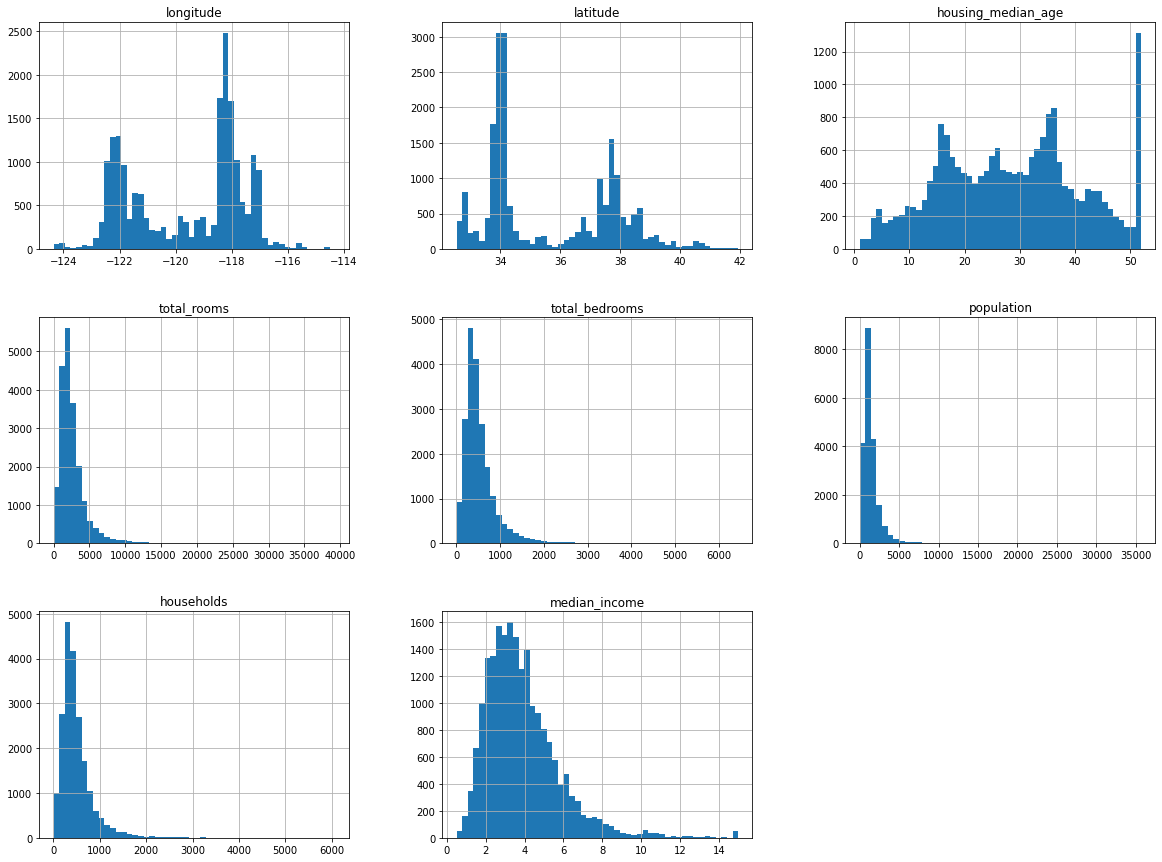

In [ ]:
# Display histogram of features
df.hist(bins=50, figsize=(20, 15))
plt.show()

# Data Modeling

> Sample Clusterings - do it without AutoML
- Arbitrary chosen parameters
- Standard-scaled data
- Silhouette index for scoring (euclidean)

> K-Means (k=4)

In [ ]:
df_sample = df.copy()
df_encoded = LabelEncoder().fit_transform(df_sample['ocean_proximity'])
df_sample.drop('ocean_proximity', axis=1, inplace=True)
df_sample['ocean_proximity'] = df_encoded

Model score:  0.2775364376624531


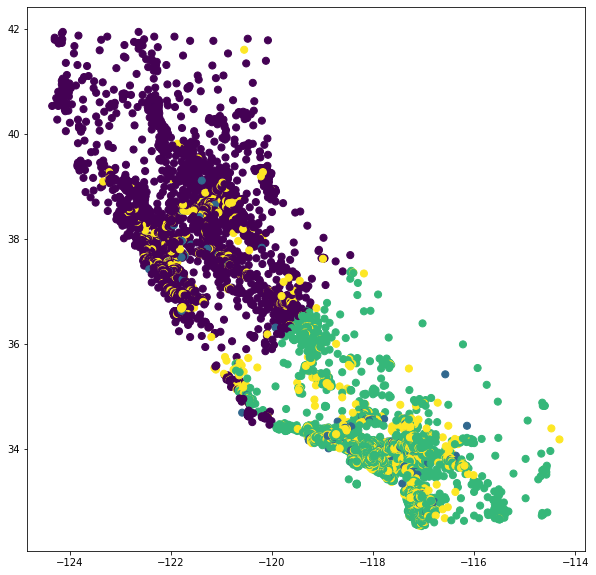

In [ ]:
X = StandardScaler().fit_transform(df_sample)
model = KMeans(n_clusters=4, random_state=1)

# Do Analysis
cluster_labels = model.fit_predict(X)

# Get info
#cluster_info = pd.DataFrame(cluster_labels).drop_duplicates().to_numpy().flatten()

# Make dataframe for each cluster
#clusters_df = []
#for i in range(0, len(cluster_info)):
#  clusters_df.append(pd.DataFrame(columns=df.columns))
#for i in range(0, len(cluster_labels)):
#  clusters_df[cluster_labels[i]] = clusters_df[cluster_labels[i]].append(df.iloc[i, :])

# Print score
print("Model score: ", silhouette_score(X, cluster_labels))

# Plots
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(df_sample.loc[:, 'longitude'], df_sample.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
plt.show()

> DBSCAN (eps=0.5, minSamples=5)

Model score:  -0.3855364054048757


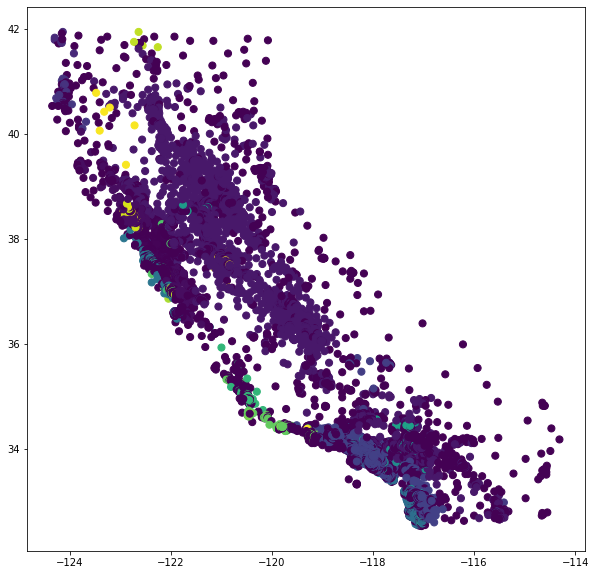

In [ ]:
X = StandardScaler().fit_transform(df_sample)
model = DBSCAN(eps=0.5, min_samples=5)

# Do analysis
cluster_labels = model.fit_predict(X)

# Print score
print("Model score: ", silhouette_score(X, cluster_labels))

# Plots
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(df_sample.loc[:, 'longitude'], df_sample.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
plt.show()

> GaussianMixture (n_components=4)

Model score:  0.11283654569879313


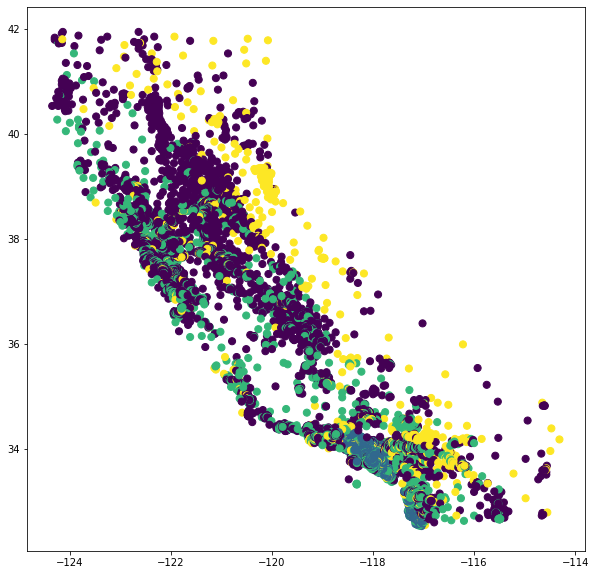

In [ ]:
X = StandardScaler().fit_transform(df_sample)
model = GaussianMixture(n_components=4, random_state=10)

# Do analysis
cluster_labels = model.fit_predict(X)

# Print score
print("Model score: ", silhouette_score(X, cluster_labels))

# Plots
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(df_sample.loc[:, 'longitude'], df_sample.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
plt.show()

> MeanShift (bandwidth=0.6)

Model score:  0.08619392227719368


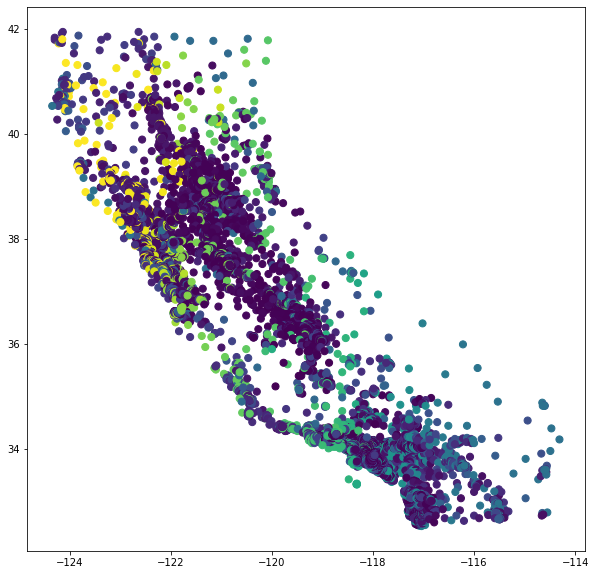

In [ ]:
X = StandardScaler().fit_transform(df_sample)
model = MeanShift(bandwidth=0.6)

# Do analysis
cluster_labels = model.fit_predict(X)

# Print score
print("Model score: ",silhouette_score(X, cluster_labels))

# Plots
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(df_sample.loc[:, 'longitude'], df_sample.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
plt.show()

> CLARANS (n_clusters=4, numlocal=1, maxneighbor=1)

Model score:  0.16318185466653656


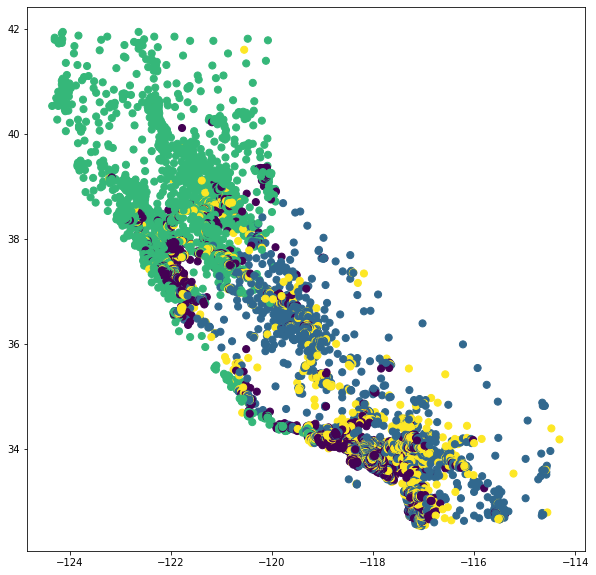

In [ ]:
X = StandardScaler().fit_transform(df_sample)

# Do analysis
model = clarans(X.tolist(), number_clusters=4, numlocal=1, maxneighbor=1)
model.process()

for i in range(0, len(model.get_clusters())):
  for index in model.get_clusters()[i]:
    cluster_labels[index] = i + 1

# Print score
print("Model score: ",silhouette_score(X, cluster_labels))

# Plots
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(df_sample.loc[:, 'longitude'], df_sample.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
plt.show()

> Processes with AutoML

In [ ]:
k_range = range(2, 13)

encoder_list = {LabelEncoder, OrdinalEncoder, OneHotEncoder}
scaler_list = {StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler}
cluster_list = {
    KMeans: {
        'n_clusters': k_range,
        'init': ['k-means++', 'random'],
        'random_state': [1]
    },
    clarans: {
       'number_clusters': k_range,
       'numlocal': [1, 2, 3],
       'maxneighbor': [1, 2, 3]
    },
    DBSCAN: {
        'eps': [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
        'min_samples': range(2, 6)
    },
    GaussianMixture: {
        'n_components': k_range,
        'random_state': [1]
    },
    MeanShift:{
        'bandwidth' : [8e-1, 16e-1, 3]
    }
}
method_list = {'euclidean', 'manhattan'}

output = major_function(df, encoder=encoder_list, scaler=scaler_list, cluster=cluster_list, metric=method_list)
print(output)

<class 'sklearn.preprocessing._encoders.OneHotEncoder'>
<class 'sklearn.preprocessing._label.LabelEncoder'>
<class 'sklearn.preprocessing._encoders.OrdinalEncoder'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Timeout from <__main__.KMeansTune object at 0x7f0a27804a90>: Model with {'n_clusters': 12, 'init': 'random', 'random_state': 1} exceed 900. Model ignored.


# Evaluation

In [ ]:
output.sort(key=lambda i:i['model'].best_score_, reverse=True)
for result in output:
  print(f'Encoder used: {result["encoder"]}')
  print(f'Scaler used: {result["scaled"]}')
  print(f'TuningModel: {result["model"]}')

  print(f'Best Parameter: {result["model"].best_params_}')
  print(f'Best Score: {result["model"].best_score_}')
  print(f'Best Model: {result["model"].best_model_}', end='\n\n')

# Comparison
- Creating cluster by median_house_value attribute to compare with AutoML function

In [ ]:
df_target = df_src.copy()

# Drop any with how=any
df_target.dropna(how='any', inplace=True)

In [ ]:
df_target.describe()

In [ ]:
# With eye-inpsection:
# 33% of data - 141300
# 66% of data - 230200

# Create target (cluster - cheap, normal, expensive)
df_target['target'] = np.NaN

# Cheap: 0, Normal: 1, Expensive: 2
df_target.loc[df_target['median_house_value'] < 141300, 'target'] = 0
df_target.loc[df_target['target'] != ('cheap'), 'target'] = 1
df_target.loc[df_target['median_house_value'] > 230200, 'target'] = 2

# Drop the median_house_value
df_target.drop(['median_house_value'], axis=1, inplace=True)

encoder = LabelEncoder()

# Encode the categorical data
df_target['ocean_proximity'] = encoder.fit_transform(df_target['ocean_proximity'])

# Print counts
print(df_target['ocean_proximity'].value_counts())
print(df_target['target'].value_counts())

In [ ]:
# Check the scores
ids = df_target['target'].copy()

# split the target for scoring
df_target.drop('target', axis=1, inplace=True)

# Calculate silhouette score
score = silhouette_score(df_target, ids)
print("silhouette score for clustering with median house value %f" % (score))

# Plot the clustering result and compare it with result of AutoML function
# Plotting clustering of median house value
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.tight_layout()
plt.title("clustering with median house value")
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.scatter(df_target['longitude'], df_target['latitude'], c=ids, cmap=get_cmap('plasma'))

# Tuning Class#2 - Comparison of Elbow, Purity scores
- **Constructor(parent)**: for Elbow (KMeans Only)
  * Since there are many variables can affect to the elbow, we only checks the n_clusters with eye-inspection.
- **Constructor(parent, y_true)**: for Purity (Common)
  * @param **parent**: ParentClass - The child class of tuning-model-class receives variables from *parent*.
  * @param **y_true**: array - a list for computing the purity (matrix)
- **check_best()**: for Purity (Common)
  * Recalculate the score of models. Make sure using this before you plot or use best model, scores.
- uses *data_target['target']* data array for y_true
- Elbow method **does not** support best parameter, you should check in eye-inspection.

In [ ]:
class KMeansTune_Elbow(KMeansTune):
    def __init__(self, parent: KMeansTune):
        if parent is not None:
            self.__dict__.update(parent.__dict__)

    def _model_scoring(self, model: KMeans, x):
        return model.inertia_
    
    def check_best(self):
        for result in self.model_list:
            result['score'] = self._model_scoring(result, None)
        
        self.best_param_ = None
        self.best_model_ = None
        self.best_score_ = None

    def plot_score(self, title: str):
        fig, axs = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)
        plt.suptitle(title)

        value_list, score_list = [], []

        key = 'n_clusters'
        values = self.params[key]

        for value in values:
            avg_score, quantity = 0, 0
            for model in self.model_list:
                if model['params'][key] == value:
                    avg_score += model['score']
                    quantity += 1

            if quantity == 0:
                continue

            value_list.append(value)
            score_list.append(avg_score / quantity)

        axs[0].set_title(f'Average score based on the value of {key}')
        axs[0].plot(value_list, score_list)
        axs[0].set_xlabel(key)
        axs[0].set_ylabel('score')


class ClaransTune_Purity(ClaransTune):
    def __init__(self, parent: ClaransTune, y_true):
        if parent is not None:
            self.__dict__.update(parent.__dict__)
        self.y_true = y_true
    
    def check_best(self):
        for result in self.model_list:
            result['score'] = self._model_scoring(result, self._dataset)
        
        super(ClaransTune_Purity, self).check_best()

    def _model_scoring(self, model: clarans, x):
        y = np.zeros(x.size // x[0].size)
        for i in range(0, len(model.get_clusters())):
            for index in model.get_clusters()[i]:
                y[index] = i + 1

        mat = contingency_matrix(self.y_true, y)
        return np.sum(np.amax(mat, axis=0)) / np.sum(mat)


class DbscanTune_Purity(DbscanTune):
    def __init__(self, parent: DbscanTune, y_true):
        if parent is not None:
            self.__dict__.update(parent.__dict__)
        self.y_true = y_true
    
    def check_best(self):
        for result in self.model_list:
            result['score'] = self._model_scoring(result, self._dataset)
        
        super(DbscanTune_Purity, self).check_best()

    def _model_scoring(self, model: DBSCAN, x):
        mat = contingency_matrix(self.y_true, model.labels_)
        return np.sum(np.amax(mat, axis=0)) / np.sum(mat)


class KMeansTune_Purity(KMeansTune):
    def __init__(self, parent: KMeansTune, y_true):
        if parent is not None:
            self.__dict__.update(parent.__dict__)
        self.y_true = y_true
    
    def check_best(self):
        for result in self.model_list:
            result['score'] = self._model_scoring(result, self._dataset)
        
        super(KMeansTune_Purity, self).check_best()

    def _model_scoring(self, model: KMeans, x):
        mat = contingency_matrix(self.y_true, model.labels_)
        return np.sum(np.amax(mat, axis=0)) / np.sum(mat)


class GMMTune_Purity(GMMTune):
    def __init__(self, parent: GMMTune, y_true):
        if parent is not None:
            self.__dict__.update(parent.__dict__)
        self.y_true = y_true
    
    def check_best(self):
        for result in self.model_list:
            result['score'] = self._model_scoring(result, self._dataset)
        
        super(GMMTune_Purity, self).check_best()

    def _model_scoring(self, model: GaussianMixture, x):
        mat = contingency_matrix(self.y_true, model.predict(x))
        return np.sum(np.amax(mat, axis=0)) / np.sum(mat)

In [ ]:
# Target classes for elbow, purity
elbow_score_target = {KMeans: KMeansTune_Elbow}
purity_score_target = {
    KMeansTune: KMeansTune_Purity,
    ClaransTune: ClaransTune_Purity,
    DbscanTune: DbscanTune_Purity,
    GMMTune: GMMTune_Purity
}

In [ ]:
for result in output:
    # Above sub-tuning classes did not use manhattan - same result skips
    if result['metric'] == 'manhattan':
        continue
    
    elbow = elbow_score_target[type(result['model'])]
    if elbow is not None:
        elbow.check_best()
        elbow.plot_scores()

    purity = purity_score_target[type(result['model'])]
    if purity is not None:
        purity.check_best()
        purity.plot_scores()

# Clustering#2 (sub dataset)
> Correlation using Matrix Heatmap - drop 4 low correlationships

In [ ]:
df = df_src.copy()

> Preprocessing

In [ ]:
# Drop any with how=any
df.dropna(how='any', inplace=True)

In [ ]:
# Display heatmap for feature engineering
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(df.corr(), annot=True, ax=ax)
plt.show()

In [ ]:
# Drop 4 attributes with low correlation coefficient with median_house_value.
drop_target = df.corr()['median_house_value'].sort_values().iloc[:4].index
print(drop_target)

In [ ]:
df.drop(list(drop_target), axis=1, inplace=True)

# Drop median_house_value (for clustering)
df.drop(['median_house_value'], axis=1, inplace=True)

> Data analysis

In [ ]:
# Same conditions of first tried, but engineered featuers (df) used
output = major_function(df, encoder=encoder_list, scaler=scaler_list, cluster=cluster_list, metric=method_list)
print(output)

> Evaluation



In [ ]:
output.sort(key = lambda i:i['model'].best_score_, reverse=True)
for result in output:
  print(f'Encoder used: {result["encoder"]}')
  print(f'Scaler used: {result["scaled"]}')
  print(f'TuningModel: {result["model"]}')

  print(f'Best Parameter: {result["model"].best_params_}')
  print(f'Best Score: {result["model"].best_score_}')
  print(f'Best Model: {result["model"].best_model_}', end='\n\n')

In [ ]:
# Same steps with above
for result in output:
    # Above sub-tuning classes did not use manhattan - same result skips
    if result['metric'] == 'manhattan':
        continue
    
    elbow = elbow_score_target[type(result['model'])]
    if elbow is not None:
        elbow.check_best()
        elbow.plot_scores()

    purity = purity_score_target[type(result['model'])]
    if purity is not None:
        purity.check_best()
        purity.plot_scores()